In [1]:
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/book-recommendation-dataset/Ratings.csv
/kaggle/input/book-recommendation-dataset/Users.csv
/kaggle/input/book-recommendation-dataset/classicRec.png
/kaggle/input/book-recommendation-dataset/Books.csv
/kaggle/input/book-recommendation-dataset/DeepRec.png
/kaggle/input/book-recommendation-dataset/recsys_taxonomy2.png


##### Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from texttable import Texttable

##### Datasets Loading

In [3]:
books = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv')
users = pd.read_csv('/kaggle/input/book-recommendation-dataset/Users.csv')
ratings = pd.read_csv('/kaggle/input/book-recommendation-dataset/Ratings.csv')

/tmp/ipykernel_34/2910231406.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv')


##### Displaying the first few rows of each dataset

In [4]:
print("Books Data:")
print(books.head())
print("\nUsers Data:")
print(users.head())
print("\nRatings Data:")
print(ratings.head())

Books Data:
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images

##### Checking the shape of the datasets

In [5]:
print("\nDataset Shapes:")
print(f"Users: {users.shape}")
print(f"Books: {books.shape}")
print(f"Ratings: {ratings.shape}")


Dataset Shapes:
Users: (278858, 3)
Books: (271360, 8)
Ratings: (1149780, 3)


##### Checking for missing values

In [6]:
print("\nMissing Values:")
print(f"Books Missing Values:\n{books.isnull().sum()}")
print(f"Users Missing Values:\n{users.isnull().sum()}")
print(f"Ratings Missing Values:\n{ratings.isnull().sum()}")


Missing Values:
Books Missing Values:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64
Users Missing Values:
User-ID          0
Location         0
Age         110762
dtype: int64
Ratings Missing Values:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


##### Checking for Duplicate values

In [8]:
print("\nDuplicate Values:")
print(f"Books Duplicate Values:\n{books.duplicated().sum()}")
print(f"Users Duplicate Values:\n{users.duplicated().sum()}")
print(f"Ratings Duplicate Values:\n{ratings.duplicated().sum()}")


Duplicate Values:
Books Duplicate Values:
0
Users Duplicate Values:
0
Ratings Duplicate Values:
0


### Exploratory Data Analysis

##### Distribution of Ratings

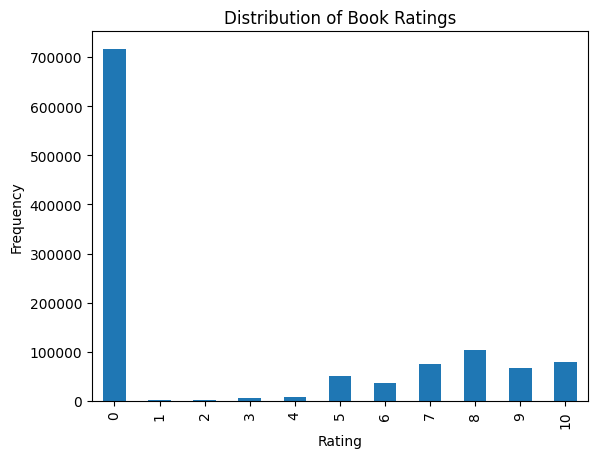

In [9]:
ratings['Book-Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

##### Most Rated Books

In [10]:
most_rated_books = ratings['ISBN'].value_counts().head(10)
most_rated_books_info = books[books['ISBN'].isin(most_rated_books.index)]
print(most_rated_books_info[['Book-Title', 'Book-Author']])

                                           Book-Title     Book-Author
26                                        Wild Animus    Rich Shapero
118                               Angels &amp; Demons       Dan Brown
305                                   A Painted House    John Grisham
356                           The Secret Life of Bees   Sue Monk Kidd
408                         The Lovely Bones: A Novel    Alice Sebold
522               The Red Tent (Bestselling Backlist)   Anita Diamant
748                                 The Da Vinci Code       Dan Brown
1105  Divine Secrets of the Ya-Ya Sisterhood: A Novel   Rebecca Wells
1922                           Snow Falling on Cedars  David Guterson


##### User Rating Behavior

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


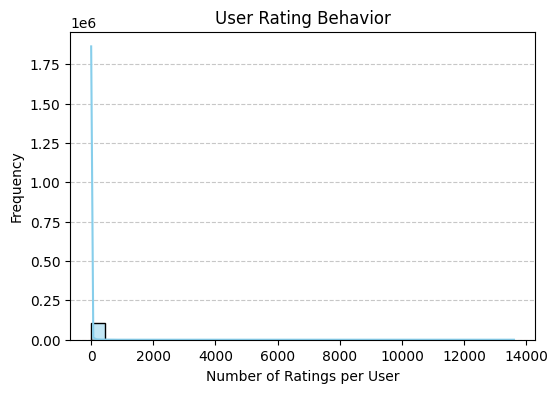

In [11]:
user_rating_count = ratings['User-ID'].value_counts()

# Plotting
plt.figure(figsize=(6, 4))
sns.histplot(user_rating_count, bins=30, color='skyblue', kde=True)
plt.title('User Rating Behavior')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### Age Distribution of Users

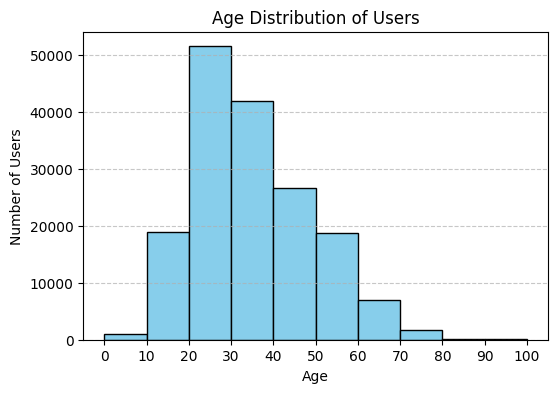

In [12]:
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Plotting
plt.figure(figsize=(6, 4))
users['Age'].plot(kind='hist', bins=age_bins, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightseagreen', 'lightpink', 'lightblue', 'lightgrey', 'lightyellow', 'lightcyan'], edgecolor='black')

plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.xticks(age_bins)  # Set x-ticks to age bins
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

##### Books Per Year

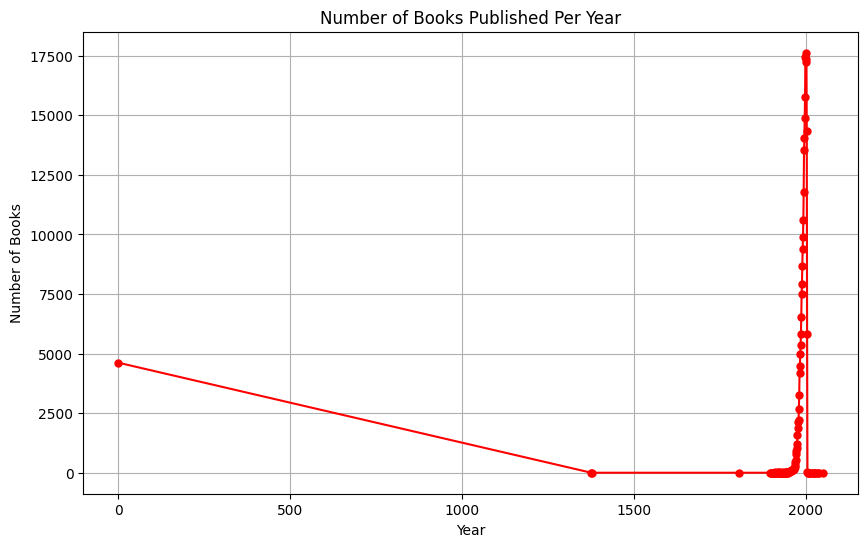

In [13]:
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

books_per_year = books['Year-Of-Publication'].value_counts().dropna().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
books_per_year.plot(kind='line', color='red', marker='o', markersize=5, linestyle='-')
plt.title('Number of Books Published Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Books')
plt.grid(True)
plt.show()

##### Location-Based Analysis

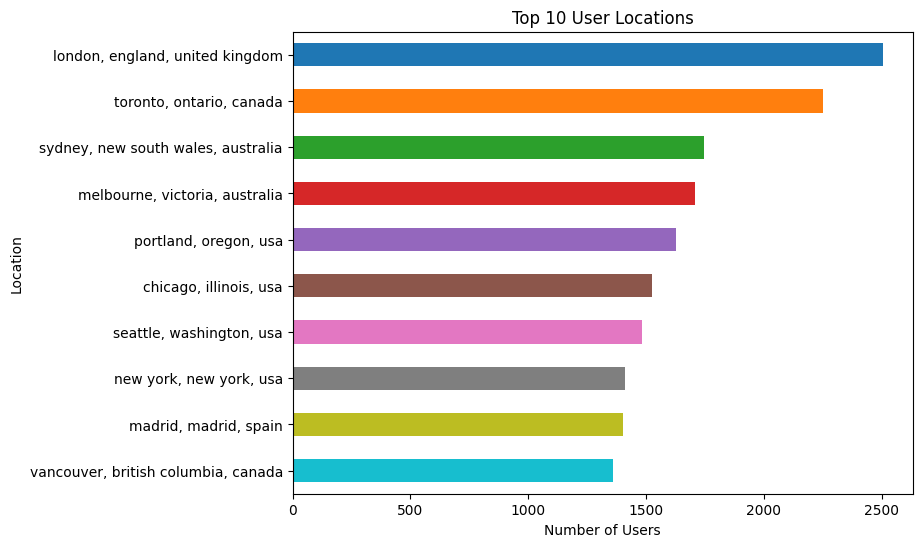

In [14]:
top_user_locations = users['Location'].value_counts().head(10)

colors = sns.color_palette("tab10")

# Plotting
plt.figure(figsize=(8, 6))
top_user_locations.plot(kind='barh', color=colors)
plt.title('Top 10 User Locations')
plt.xlabel('Number of Users')
plt.ylabel('Location')
plt.gca().invert_yaxis()
plt.show()

##### Publisher Analysis

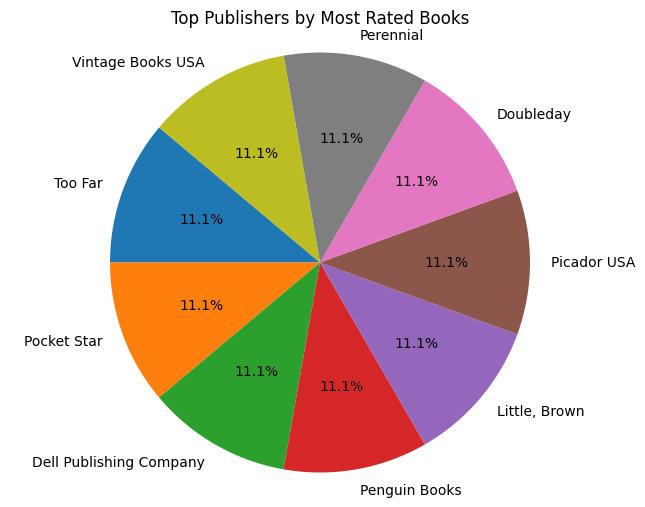

In [15]:
top_publishers = books[books['ISBN'].isin(most_rated_books.index)]['Publisher'].value_counts().head(10)

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(top_publishers, labels=top_publishers.index, autopct='%1.1f%%', startangle=140)
plt.title('Top Publishers by Most Rated Books')
plt.axis('equal') 
plt.show()

### Collaborative Filtering Based Recommender System

###### Merging ratings with book details

In [16]:

ratings_with_name = ratings.merge(books, on='ISBN', how='inner')

In [17]:
ratings_with_name

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996.0,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
...,...,...,...,...,...,...,...,...,...,...
1031131,276704,0876044011,0,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,1998.0,A.R.E. Press (Association of Research &amp; Enlig,http://images.amazon.com/images/P/0876044011.0...,http://images.amazon.com/images/P/0876044011.0...,http://images.amazon.com/images/P/0876044011.0...
1031132,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000.0,Longstreet Press,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...
1031133,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997.0,Alfred A. Knopf,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...
1031134,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996.0,Jove Books,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...


###### Identifying 'educated' users who have rated more than 200 books

In [18]:
ratings_per_user = ratings_with_name.groupby('User-ID').size()
educated_users = ratings_per_user[ratings_per_user > 200].index

In [19]:
educated_users

Index([   254,   2276,   2766,   2977,   3363,   4017,   4385,   6251,   6323,
         6543,
       ...
       271705, 273979, 274004, 274061, 274301, 274308, 275970, 277427, 277639,
       278418],
      dtype='int64', name='User-ID', length=811)

###### Filtering ratings for 'educated' users

In [20]:
educated_ratings = ratings_with_name[ratings_with_name['User-ID'].isin(educated_users)]

In [21]:
educated_ratings

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1150,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
1151,277427,0026217457,0,Vegetarian Times Complete Cookbook,Lucy Moll,1995.0,John Wiley &amp; Sons,http://images.amazon.com/images/P/0026217457.0...,http://images.amazon.com/images/P/0026217457.0...,http://images.amazon.com/images/P/0026217457.0...
1152,277427,003008685X,8,Pioneers,James Fenimore Cooper,1974.0,Thomson Learning,http://images.amazon.com/images/P/003008685X.0...,http://images.amazon.com/images/P/003008685X.0...,http://images.amazon.com/images/P/003008685X.0...
1153,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",G. B. Trudeau,1982.0,Henry Holt &amp; Co,http://images.amazon.com/images/P/0030615321.0...,http://images.amazon.com/images/P/0030615321.0...,http://images.amazon.com/images/P/0030615321.0...
1154,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,2002.0,Avon Books,http://images.amazon.com/images/P/0060002050.0...,http://images.amazon.com/images/P/0060002050.0...,http://images.amazon.com/images/P/0060002050.0...
...,...,...,...,...,...,...,...,...,...,...
1029357,275970,1931868123,0,There's a Porcupine in My Outhouse: Misadventu...,Mike Tougias,2002.0,Capital Books (VA),http://images.amazon.com/images/P/1931868123.0...,http://images.amazon.com/images/P/1931868123.0...,http://images.amazon.com/images/P/1931868123.0...
1029358,275970,3411086211,10,Die Biene.,Sybil GrÃ?Â¤fin SchÃ?Â¶nfeldt,1993.0,"Bibliographisches Institut, Mannheim",http://images.amazon.com/images/P/3411086211.0...,http://images.amazon.com/images/P/3411086211.0...,http://images.amazon.com/images/P/3411086211.0...
1029359,275970,3829021860,0,The Penis Book,Joseph Cohen,1999.0,Konemann,http://images.amazon.com/images/P/3829021860.0...,http://images.amazon.com/images/P/3829021860.0...,http://images.amazon.com/images/P/3829021860.0...
1029360,275970,4770019572,0,Musashi,Eiji Yoshikawa,1995.0,Kodansha International (JPN),http://images.amazon.com/images/P/4770019572.0...,http://images.amazon.com/images/P/4770019572.0...,http://images.amazon.com/images/P/4770019572.0...


###### Determining if each book has at least 50 ratings from 'educated' users

In [22]:
is_famous_book = educated_ratings['Book-Title'].value_counts() >= 50

In [23]:
is_famous_book

Book-Title
Wild Animus                   True
Bridget Jones's Diary         True
The Lovely Bones: A Novel     True
The Notebook                  True
The Pelican Brief             True
                             ...  
Untamed (Mira)               False
The Roofer (Mira)            False
Wedding Ring                 False
Just Trust Me (Mira)         False
Musashi                      False
Name: count, Length: 155845, dtype: bool

###### Extracting the titles of famous books

In [24]:
famous_books = is_famous_book[is_famous_book].index

In [25]:
famous_books

Index(['Wild Animus', 'Bridget Jones's Diary', 'The Lovely Bones: A Novel',
       'The Notebook', 'The Pelican Brief',
       'Divine Secrets of the Ya-Ya Sisterhood: A Novel', 'A Painted House',
       'The Nanny Diaries: A Novel', 'The Firm', 'The Da Vinci Code',
       ...
       'The Face of Deception', 'Tales of a Fourth Grade Nothing',
       'Like Water for Chocolate: A Novel in Monthly Installments, With Recipes, Romances, and Home Remedies',
       'Smart Women', 'Bleachers', 'Gorky Park', 'Watermelon',
       'The Phantom Tollbooth',
       'Guilty Pleasures (Anita Blake Vampire Hunter (Paperback))',
       'The Fourth Hand'],
      dtype='object', name='Book-Title', length=706)

###### Filtering 'educated' ratings for famous books

In [26]:
final_ratings = educated_ratings[educated_ratings['Book-Title'].isin(famous_books)]

In [27]:
final_ratings

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1150,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
1163,277427,0060930535,0,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999.0,Perennial,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...
1165,277427,0060934417,0,Bel Canto: A Novel,Ann Patchett,2002.0,Perennial,http://images.amazon.com/images/P/0060934417.0...,http://images.amazon.com/images/P/0060934417.0...,http://images.amazon.com/images/P/0060934417.0...
1168,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,1995.0,HarperTorch,http://images.amazon.com/images/P/0061009059.0...,http://images.amazon.com/images/P/0061009059.0...,http://images.amazon.com/images/P/0061009059.0...
1174,277427,006440188X,0,The Secret Garden,Frances Hodgson Burnett,1998.0,HarperTrophy,http://images.amazon.com/images/P/006440188X.0...,http://images.amazon.com/images/P/006440188X.0...,http://images.amazon.com/images/P/006440188X.0...
...,...,...,...,...,...,...,...,...,...,...
1029196,275970,1400031354,0,Tears of the Giraffe (No.1 Ladies Detective Ag...,Alexander McCall Smith,2002.0,Anchor,http://images.amazon.com/images/P/1400031354.0...,http://images.amazon.com/images/P/1400031354.0...,http://images.amazon.com/images/P/1400031354.0...
1029197,275970,1400031362,0,Morality for Beautiful Girls (No.1 Ladies Dete...,Alexander McCall Smith,2002.0,Anchor,http://images.amazon.com/images/P/1400031362.0...,http://images.amazon.com/images/P/1400031362.0...,http://images.amazon.com/images/P/1400031362.0...
1029270,275970,1573229725,0,Fingersmith,Sarah Waters,2002.0,Riverhead Books,http://images.amazon.com/images/P/1573229725.0...,http://images.amazon.com/images/P/1573229725.0...,http://images.amazon.com/images/P/1573229725.0...
1029309,275970,1586210661,9,Me Talk Pretty One Day,David Sedaris,2001.0,Time Warner Audio Major,http://images.amazon.com/images/P/1586210661.0...,http://images.amazon.com/images/P/1586210661.0...,http://images.amazon.com/images/P/1586210661.0...


###### Creating the pivot table for the recommender system

In [28]:
pt = final_ratings.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating')

In [29]:
pt

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bend in the Road,0.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,9.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
You Belong To Me,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


##### Setting the style and Plotting the heatmap of the pivot table

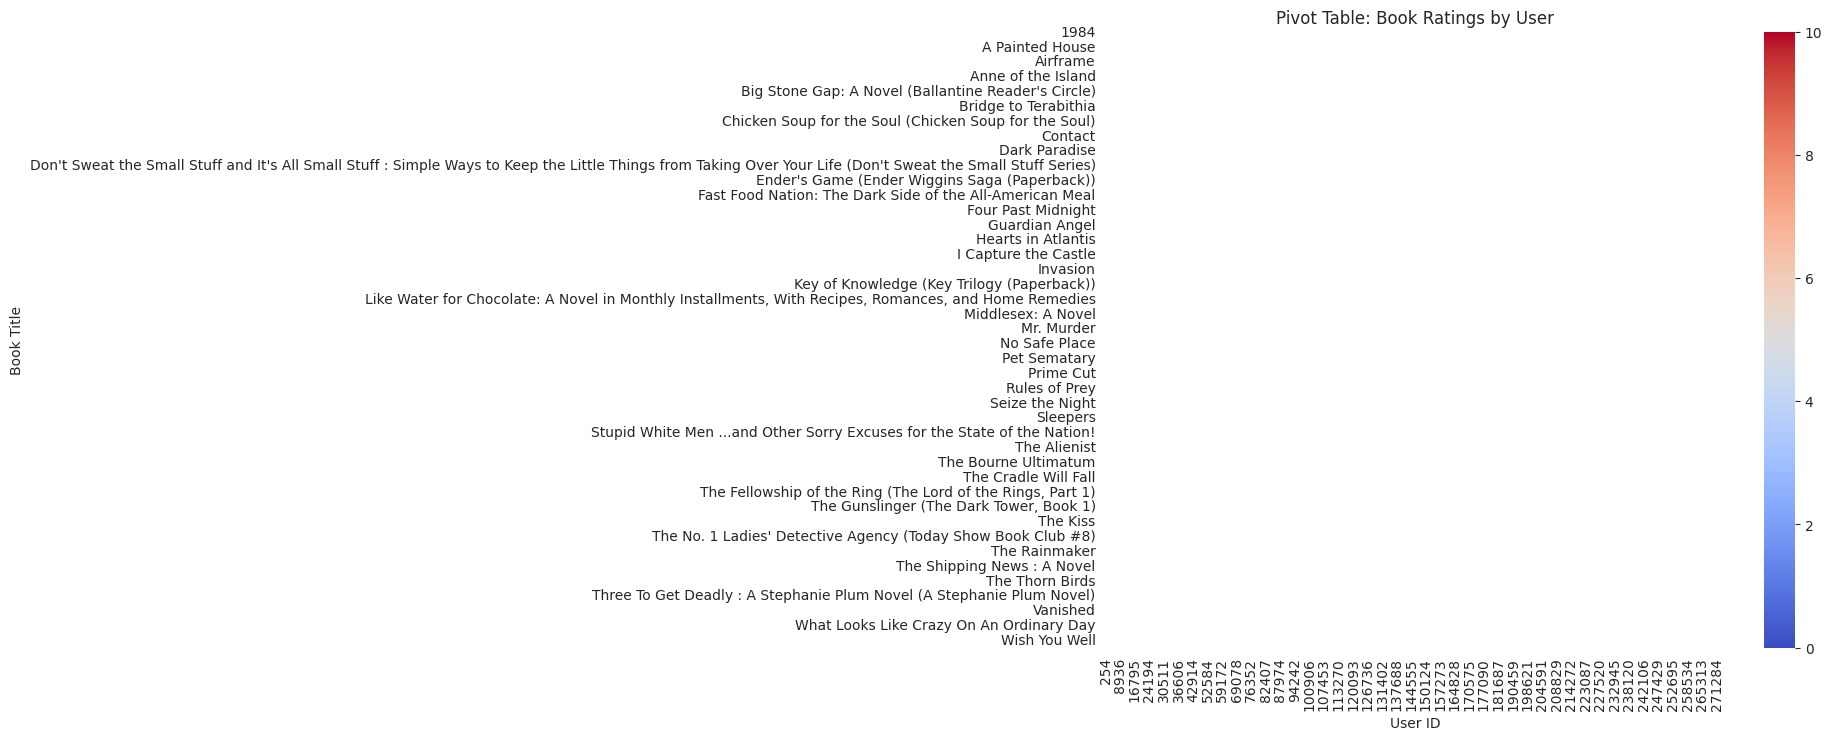

In [30]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 8))
sns.heatmap(pt, cmap="coolwarm", linewidths=0.5)
plt.title('Pivot Table: Book Ratings by User')
plt.xlabel('User ID')
plt.ylabel('Book Title')
plt.show()

###### Filling missing values with 0 in the pivot table

In [31]:
pt.fillna(0, inplace=True)
pt

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculating the cosine similarity scores

In [32]:
similarity_scores = cosine_similarity(pt)

### Defining the recommendation function

In [33]:
def recommend(book_name, similarity_scores, pt, books):
    # Find the index of the specified book
    index = pt.index.get_loc(book_name)
   
    # Sort similar items based on similarity scores
    similar_items = sorted(enumerate(similarity_scores[index]), key=lambda x: x[1], reverse=True)[1:5]
   
    # Prepare data for recommended books
    recommended_books = []
    for i, sim_score in similar_items:
        # Fetch book details
        similar_book = books[books['Book-Title'] == pt.index[i]].drop_duplicates(subset='Book-Title')
        book_title = similar_book['Book-Title'].values[0]
        book_author = similar_book['Book-Author'].values[0]
       
        # Append book details to the recommended books list
        recommended_books.append({'Title': book_title, 'Author': book_author})
   
    return recommended_books

### Selecting a book to test the recommendation system

In [34]:
selected_book = "1984"
recommended_books = recommend(selected_book, similarity_scores, pt, books)

### Displaying recommended books as a text-based table

In [35]:
table = Texttable()
table.set_cols_align(["c", "c"])
table.header(["Title", "Author"])
for book in recommended_books:
    table.add_row([book['Title'], book['Author']])
print(f"Recommended books for '{selected_book}':")
print(table.draw())

Recommended books for '1984':
+--------------------------------------------------+-----------------+
|                      Title                       |     Author      |
+==================================================+=================+
|                   Animal Farm                    |  George Orwell  |
+--------------------------------------------------+-----------------+
|               The Handmaid's Tale                | Margaret Atwood |
+--------------------------------------------------+-----------------+
|                 Brave New World                  |  Aldous Huxley  |
+--------------------------------------------------+-----------------+
| The Vampire Lestat (Vampire Chronicles, Book II) |    ANNE RICE    |
+--------------------------------------------------+-----------------+


### Function to collect user feedback on recommended books

In [36]:
def collect_feedback(recommended_books):
    feedback = {}
    print("Please provide your feedback on the recommended books (1-5 scale, 5 being the best):")
    for book in recommended_books:
        score = input(f"How do you rate '{book['Title']}' by {book['Author']}? ")
        feedback[book['Title']] = int(score)
    return feedback

### Function to update the user's preferences based on feedback

In [37]:
def update_preferences(user_preferences, feedback):
    for title, score in feedback.items():
        if score > 3: #Score above 3 is positive
            user_preferences['liked_books'].add(title)
        elif score < 3: #Score below 3 is negative
            user_preferences['disliked_books'].add(title)
    return user_preferences

### Function to refine recommendations based on updated preferences

In [38]:
def refine_recommendations(recommended_books, user_preferences):
    refined_recommendations = []
    for book in recommended_books:
        if book['Title'] not in user_preferences['disliked_books']:
            refined_recommendations.append(book)
    return refined_recommendations

In [39]:
user_preferences = {
    'liked_books': set(),
    'disliked_books': set()
}

### Assuming 'recommended_books' is a list of books recommended previously

In [40]:
feedback = collect_feedback(recommended_books)
user_preferences = update_preferences(user_preferences, feedback)
refined_recommendations = refine_recommendations(recommended_books, user_preferences)

Please provide your feedback on the recommended books (1-5 scale, 5 being the best):


How do you rate 'Animal Farm' by George Orwell?  3
How do you rate 'The Handmaid's Tale' by Margaret Atwood?  4
How do you rate 'Brave New World' by Aldous Huxley?  5
How do you rate 'The Vampire Lestat (Vampire Chronicles, Book II)' by ANNE RICE?  2


### Display refined recommendations

In [41]:
print("Refined Recommendations based on your feedback:")
for book in refined_recommendations:
    print(f"{book['Title']} by {book['Author']}")

Refined Recommendations based on your feedback:
Animal Farm by George Orwell
The Handmaid's Tale by Margaret Atwood
Brave New World by Aldous Huxley
